In [ ]:
# Imports
import os
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm

# Utility function to generate a 2D grid of coordinates
def get_mgrid_2d(height, width, dim=2):
    x = torch.linspace(-1, 1, steps=width)
    y = torch.linspace(-1, 1, steps=height)
    mgrid = torch.stack(torch.meshgrid(y, x, indexing="ij"), dim=-1)
    return mgrid.reshape(-1, dim)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Minimal functions needed for the Multiple Image Siren LIIF implementation to work

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate

In [ ]:
class ConditionedSiren(nn.Module):
    def __init__(self, patch_size=3, hidden_dim=256):
        super().__init__()
        # Correct input dimension calculation (2 coords + 3*(3x3-1) patch values)
        input_dim = 2 + 3*(patch_size**2 - 1)  # Now 26 dimensions (2 + 24)

        self.net = nn.Sequential(
            SineLayer(input_dim, hidden_dim, is_first=True),
            SineLayer(hidden_dim, hidden_dim),
            SineLayer(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, coord, patch):
        x = torch.cat([coord, patch], dim=-1)
        return self.net(x)


In [ ]:
class SingleImagePatchDataset(Dataset):
    def __init__(self, image_path, img_size=(256, 256), patch_size=3):
        super().__init__()
        self.patch_size = patch_size
        self.pad_size = patch_size // 2

        # Load and process image
        img = Image.open(image_path).convert('RGB')
        img = img.resize(img_size)
        self.img_tensor = torch.from_numpy(np.array(img)).float() / 127.5 - 1.0  # [-1, 1]
        self.img_tensor = self.img_tensor.permute(2, 0, 1)  # CxHxW

        # Create coordinates grid
        self.coords = get_mgrid_2d(img_size[1], img_size[0])

    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, idx):
        # Get target pixel
        c, h, w = self.img_tensor.shape
        y = idx // w
        x = idx % w

        # Extract patch with reflection padding
        padded_img = F.pad(self.img_tensor.unsqueeze(0),
                          (self.pad_size,)*4, mode='reflect')[0]

        # Modified patch processing
        patch = padded_img[:, y:y+self.patch_size, x:x+self.patch_size]
        patch = patch.reshape(3, -1)  # [3, 9]

        # Remove center element (index 4 in 0-indexed 3x3 grid)
        patch = torch.cat([patch[:, :4], patch[:, 5:]], dim=1)  # [3, 8]
        patch = patch.flatten()  # [24]

        return {
            'coord': self.coords[idx],
            'patch': patch,
            'target': self.img_tensor[:, y, x]
        }

# Super resolution Dataset

In [ ]:
class SuperResolutionDataset(Dataset):
  def __init__(self, hr_image_path, img_size=(256, 256), scale_factor=4, patch_size=3):
    super().__init__()
    self.patch_size = patch_size
    self.pad_size = patch_size // 2
    self.scale_factor = scale_factor

    # Load HR image
    hr_img = Image.open(hr_image_path).convert('RGB')
    hr_img = hr_img.resize(img_size)
    # Calculate LR size
    lr_width = hr_img.size[0] // scale_factor
    lr_height = hr_img.size[1] // scale_factor

    # Create LR image
    lr_img = hr_img.resize((lr_width, lr_height), Image.BICUBIC)

    # Convert to tensors and normalize to [-1, 1]
    self.hr_tensor = torch.from_numpy(np.array(hr_img)).float() / 127.5 - 1.0
    self.lr_tensor = torch.from_numpy(np.array(lr_img)).float() / 127.5 - 1.0

    # Permute to CxHxW
    self.hr_tensor = self.hr_tensor.permute(2, 0, 1)
    self.lr_tensor = self.lr_tensor.permute(2, 0, 1)

    # Create coordinates grid for HR image
    self.coords = get_mgrid_2d(hr_img.size[1], hr_img.size[0])

  def __len__(self):
      return self.coords.shape[0]

  def __getitem__(self, idx):
      # Get target pixel from HR image
      c, h, w = self.hr_tensor.shape
      y = idx // w
      x = idx % w

      # Get corresponding position in LR image
      lr_y = y // self.scale_factor
      lr_x = x // self.scale_factor

      # Extract patch from LR image with reflection padding
      padded_lr = F.pad(self.lr_tensor.unsqueeze(0), (self.pad_size,)*4, mode='reflect')[0]
      patch = padded_lr[:, lr_y:lr_y+self.patch_size, lr_x:lr_x+self.patch_size]
      patch = patch.reshape(3, -1)  # [3, 9]

      # Remove center element
      patch = torch.cat([patch[:, :4], patch[:, 5:]], dim=1)  # [3, 8]
      patch = patch.flatten()  # [24]

      return {
          'coord': self.coords[idx],
          'patch': patch,
          'target': self.hr_tensor[:, y, x]
      }

In [ ]:
class ImprovedConditionedSiren(nn.Module):
  def __init__(self, patch_size=3, hidden_dim=256):
    super().__init__()
    input_dim = 2 + 3*(patch_size**2 - 1) # 2 coords + patch values

        # Initial layer
    self.input_layer = SineLayer(input_dim, hidden_dim, is_first=True)

    # Multiple SIREN layers with skip connections
    self.layers = nn.ModuleList([
        SineLayer(hidden_dim, hidden_dim) for _ in range(4)
    ])

    # Final output layer
    self.output_layer = nn.Linear(hidden_dim, 3)

    # Skip connection mixing parameters
    self.skip_weights = nn.Parameter(torch.ones(8))
    self.softmax = nn.Softmax(dim=0)

  def forward(self, coord, patch):
    x = torch.cat([coord, patch], dim=-1)

    # Initial layer
    x = self.input_layer(x)

    # Store intermediate outputs for skip connections
    intermediates = []
    for layer in self.layers:
        x = layer(x)
        intermediates.append(x)

    # Weighted sum of all intermediate outputs
    weights = self.softmax(self.skip_weights)
    x = sum(w * output for w, output in zip(weights, intermediates))

    return self.output_layer(x)

In [ ]:
class TrainingConfig:
  def __init__(self):
    self.epochs = 20 # Increased from 2
    self.batch_size = 512 # Reduced from 2048 for better stability
    self.lr = 1e-4
    self.scale_factor = 2 # Super-resolution scale factor
    self.num_train_images = 10 # Increased from 4
    self.visualize_every = 5

        # Scheduler parameters
    self.use_scheduler = True
    self.scheduler_factor = 0.5
    self.scheduler_patience = 5
    self.min_lr = 1e-6

    # Model parameters
    self.hidden_dim = 256
    self.patch_size = 3


In [ ]:
config = TrainingConfig()

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def train_super_resolution(config):
  # Data preparation
  data_folder = '/content/drive/MyDrive/data/DIV2K_train_HR'
  image_paths = [os.path.join(data_folder, fname) for fname in os.listdir(data_folder) if fname.endswith(('.png', '.jpg', '.jpeg'))]
  # Split train/val
  train_paths = image_paths[:config.num_train_images]
  val_paths = image_paths[config.num_train_images:config.num_train_images+2]

  # Create datasets
  train_datasets = [SuperResolutionDataset(path, scale_factor=config.scale_factor)
                  for path in train_paths]
  val_datasets = [SuperResolutionDataset(path, scale_factor=config.scale_factor)
                for path in val_paths]

  train_dataset = torch.utils.data.ConcatDataset(train_datasets)
  val_dataset = torch.utils.data.ConcatDataset(val_datasets)

  # Data loaders
  train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)

  # Model and optimizer
  device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
  model = ImprovedConditionedSiren(
      patch_size=config.patch_size,
      hidden_dim=config.hidden_dim
  ).to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

  if config.use_scheduler:
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer, mode='min', factor=config.scheduler_factor,
          patience=config.scheduler_patience, min_lr=config.min_lr
      )

  # Training loop
  best_val_loss = float('inf')
  train_losses = []
  val_losses = []

  for epoch in tqdm(range(config.epochs)):
      # Training
      model.train()
      train_loss = 0
      for i, batch in enumerate(train_loader):
          print(i)
          coords = batch['coord'].to(device)
          patches = batch['patch'].to(device)
          targets = batch['target'].to(device)

          preds = model(coords, patches)
          loss = F.mse_loss(preds, targets)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()

      train_loss /= len(train_loader)
      train_losses.append(train_loss)

      # Validation
      model.eval()
      val_loss = 0
      with torch.no_grad():
          for batch in val_loader:
              coords = batch['coord'].to(device)
              patches = batch['patch'].to(device)
              targets = batch['target'].to(device)

              preds = model(coords, patches)
              val_loss += F.mse_loss(preds, targets).item()

      val_loss /= len(val_loader)
      val_losses.append(val_loss)

      # Scheduler step
      if config.use_scheduler:
          scheduler.step(val_loss)

      # Save best model
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_super_res_model.pth')

      # Print progress
      print(f"Epoch {epoch+1}/{config.epochs}")
      print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
      print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

      # Visualize progress
      if (epoch + 1) % config.visualize_every == 0:
          visualize_results(model, val_datasets[0], device)

SyntaxError: cannot assign to function call (<ipython-input-143-fcccadb8cc46>, line 46)

In [ ]:
def visualize_results(model, dataset, device):
  model.eval()
  with torch.no_grad(): # Get original LR and HR images
    lr_img = (dataset.lr_tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2
    hr_img = (dataset.hr_tensor.permute(1, 2, 0).cpu().numpy() + 1) / 2

      # Generate SR image
    coords = dataset.coords.to(device)
    h, w = dataset.hr_tensor.shape[1:]
    patches = []

    for i in range(0, coords.shape[0], 1024):  # Process in batches
        batch_coords = coords[i:i+1024]
        batch_idx = torch.arange(i, min(i+1024, coords.shape[0]))
        batch_patches = torch.stack([dataset[idx.item()]['patch'] for idx in batch_idx])
        patches.append(batch_patches)

    patches = torch.cat(patches, dim=0).to(device)
    preds = model(coords, patches)
    sr_img = preds.cpu().numpy().reshape(h, w, 3)
    sr_img = (sr_img + 1) / 2

    # Display results
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(lr_img.clip(0, 1))
    plt.title('Low Resolution')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(sr_img.clip(0, 1))
    plt.title('Super Resolution')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(hr_img.clip(0, 1))
    plt.title('High Resolution')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


  0%|          | 0/20 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

  5%|▌         | 1/20 [02:27<46:44, 147.63s/it]

Epoch 1/20
Train Loss: 0.028548, Val Loss: 0.011806
LR: 1.00e-04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 10%|█         | 2/20 [04:51<43:38, 145.46s/it]

Epoch 2/20
Train Loss: 0.026797, Val Loss: 0.013215
LR: 1.00e-04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 15%|█▌        | 3/20 [07:14<40:54, 144.38s/it]

Epoch 3/20
Train Loss: 0.027026, Val Loss: 0.012958
LR: 1.00e-04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 20%|██        | 4/20 [09:37<38:22, 143.88s/it]

Epoch 4/20
Train Loss: 0.027274, Val Loss: 0.013267
LR: 1.00e-04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

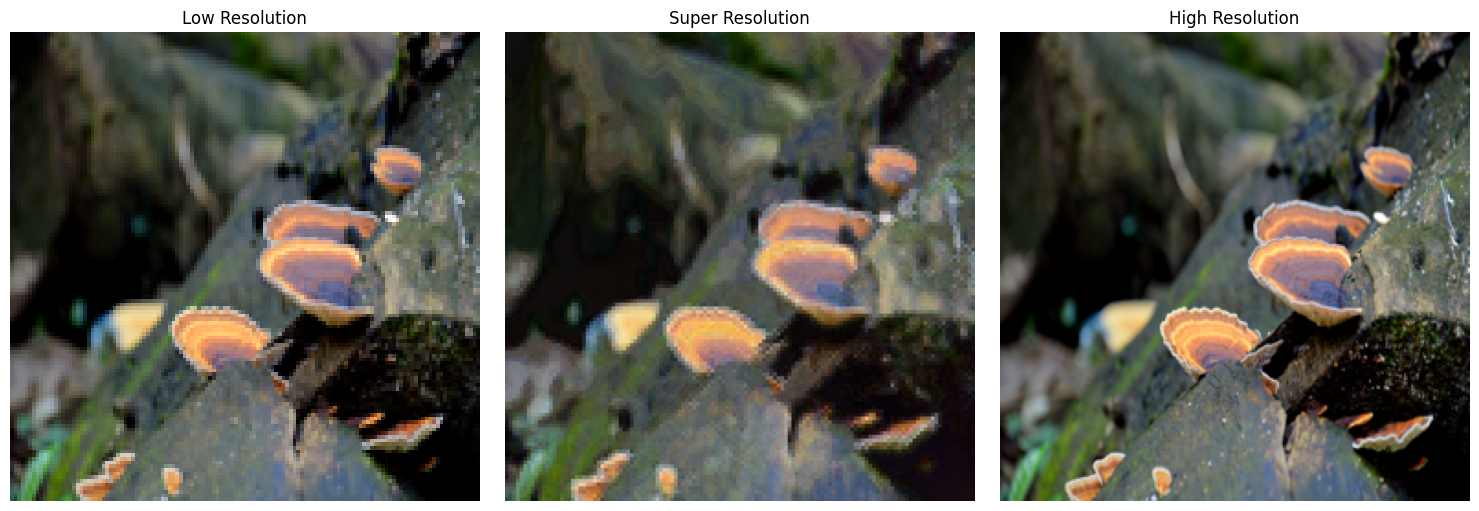

 25%|██▌       | 5/20 [12:12<36:57, 147.81s/it]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 30%|███       | 6/20 [14:37<34:15, 146.79s/it]

Epoch 6/20
Train Loss: 0.027315, Val Loss: 0.013364
LR: 1.00e-04
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 35%|███▌      | 7/20 [17:02<31:41, 146.31s/it]

Epoch 7/20
Train Loss: 0.027337, Val Loss: 0.013593
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 40%|████      | 8/20 [19:27<29:11, 145.94s/it]

Epoch 8/20
Train Loss: 0.026042, Val Loss: 0.012055
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

 45%|████▌     | 9/20 [21:53<26:45, 145.95s/it]

Epoch 9/20
Train Loss: 0.025517, Val Loss: 0.011622
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
2

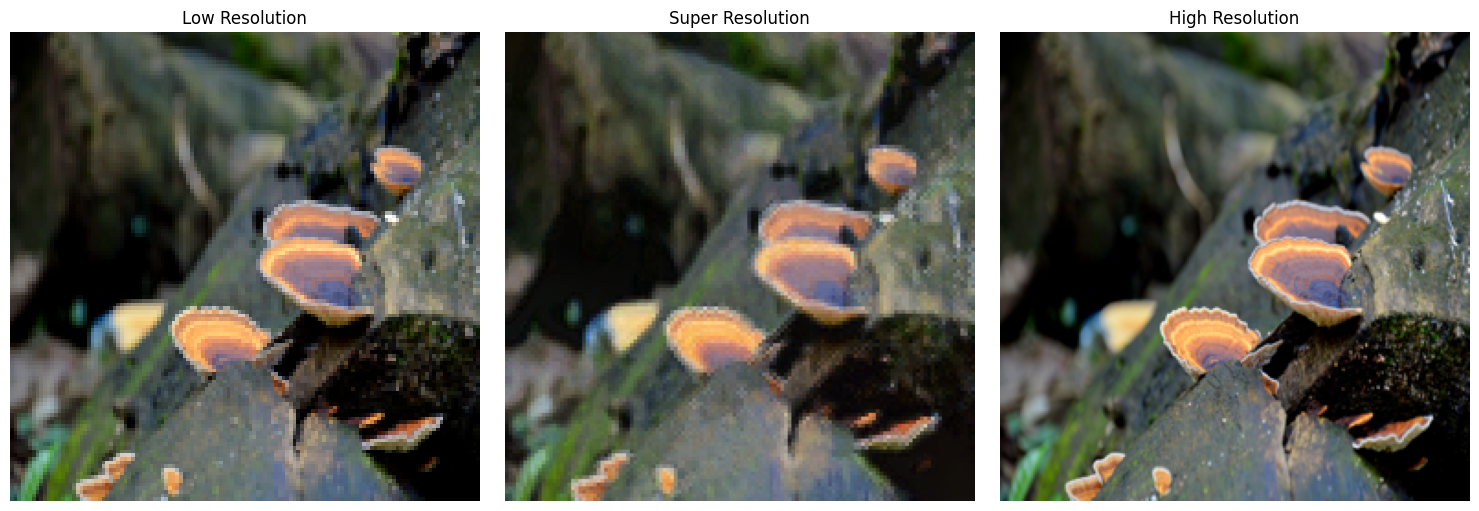

 50%|█████     | 10/20 [24:30<24:53, 149.32s/it]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 55%|█████▌    | 11/20 [26:57<22:16, 148.45s/it]

Epoch 11/20
Train Loss: 0.025165, Val Loss: 0.013637
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 60%|██████    | 12/20 [29:23<19:43, 147.89s/it]

Epoch 12/20
Train Loss: 0.025069, Val Loss: 0.011984
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 65%|██████▌   | 13/20 [31:50<17:12, 147.54s/it]

Epoch 13/20
Train Loss: 0.024962, Val Loss: 0.012045
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 70%|███████   | 14/20 [34:17<14:43, 147.26s/it]

Epoch 14/20
Train Loss: 0.024912, Val Loss: 0.011796
LR: 5.00e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


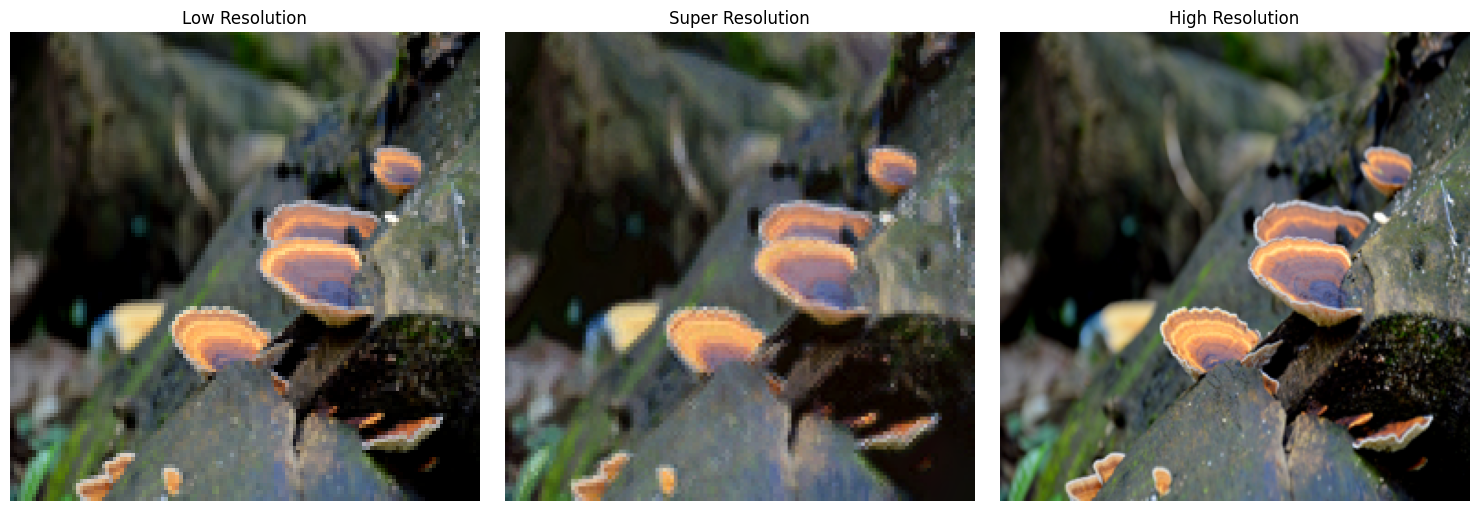

 75%|███████▌  | 15/20 [36:55<12:33, 150.67s/it]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

 80%|████████  | 16/20 [39:23<09:58, 149.69s/it]

Epoch 16/20
Train Loss: 0.024068, Val Loss: 0.011532
LR: 2.50e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 85%|████████▌ | 17/20 [41:52<07:28, 149.64s/it]

Epoch 17/20
Train Loss: 0.023688, Val Loss: 0.011660
LR: 2.50e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 90%|█████████ | 18/20 [44:24<05:00, 150.28s/it]

Epoch 18/20
Train Loss: 0.023448, Val Loss: 0.012240
LR: 2.50e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


 95%|█████████▌| 19/20 [46:55<02:30, 150.44s/it]

Epoch 19/20
Train Loss: 0.023249, Val Loss: 0.011851
LR: 2.50e-05
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


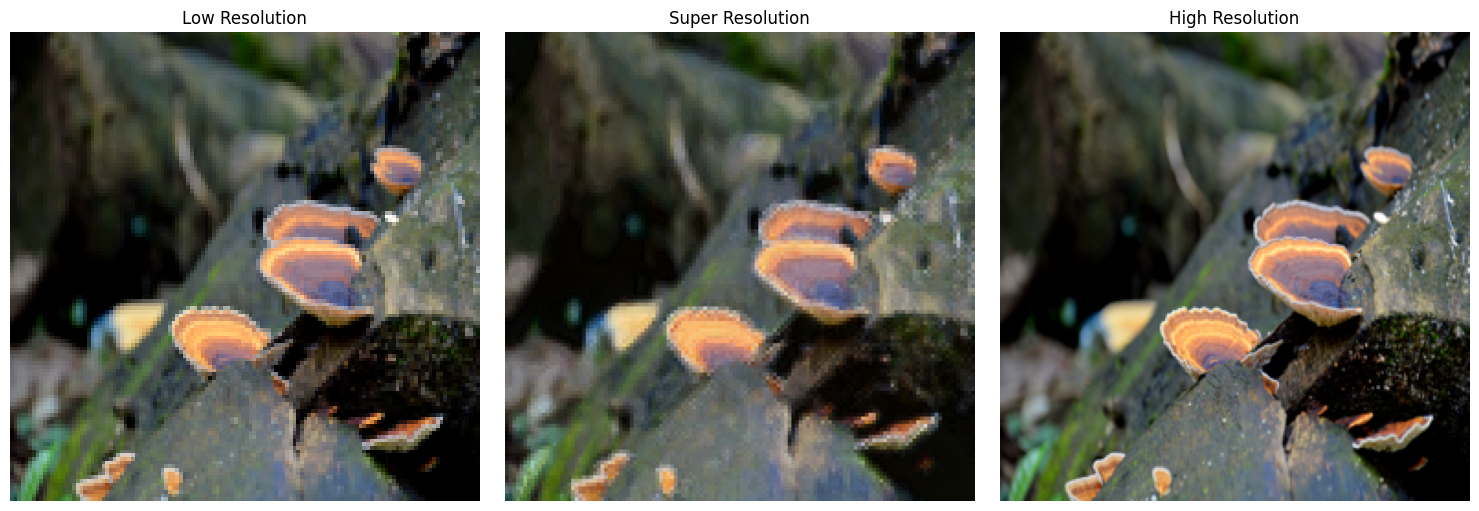

100%|██████████| 20/20 [49:38<00:00, 148.91s/it]


In [ ]:
train_super_resolution(config)